WSC - initial data prep
* read in pickle
* split into chapters
* run several functions to chunk the text
* all in dataframes this time compared to lists in tex_prep_v02

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import textacy
import re

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


Bad key "text.kerning_factor" on line 4 in
/Users/Steven/opt/anaconda3/envs/textacy/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import pickle

In [3]:
book_dict = {'The Elephant Vanishes': 'ev_birnbaum_rubin_v01', 
             'Norwegian Wood 1': 'nw_birnbaum_v01', 
             'Norwegian Wood 2': 'nw_rubin_v01',
             'Wild Sheep Chase': 'wsc_birnbaum_v01', 
             'Wind Up Bird Chronicle': 'wubc_all_rubin_v01', 
             'Sputnik Sweetheart': 'ss_gabriel_v01',
             'Kafka on the Shore': 'kots_gabriel_v01'}

In [4]:
books = pd.DataFrame.from_dict(book_dict, orient='index').reset_index()
books.columns = ['Title', 'Pickle']
books

,Title,Pickle
0,The Elephant Vanishes,ev_birnbaum_rubin_v01
1,Norwegian Wood 1,nw_birnbaum_v01
2,Norwegian Wood 2,nw_rubin_v01
3,Wild Sheep Chase,wsc_birnbaum_v01
4,Wind Up Bird Chronicle,wubc_all_rubin_v01
5,Sputnik Sweetheart,ss_gabriel_v01
6,Kafka on the Shore,kots_gabriel_v01


In [5]:
def load_pickle(filename):
    in_path = '../../../../Documents/murakami/pkl/' + filename + '.pkl'
    with open (in_path, 'rb') as fp:
        return pickle.load(fp)

In [6]:
books['full_text'] = books['Pickle'].apply(load_pickle)

In [7]:
books

,Title,Pickle,full_text
0,The Elephant Vanishes,ev_birnbaum_rubin_v01,I’M IN THE kitchen cooking spaghetti when the ...
1,Norwegian Wood 1,nw_birnbaum_v01,C H II P T E R 6 (rontinutd) The scene at dinn...
2,Norwegian Wood 2,nw_rubin_v01,[Haruki Murakami Norwegian Wood This book was ...
3,Wild Sheep Chase,wsc_birnbaum_v01,"[\n , \n \n \n , Contents \n Cover \n About th..."
4,Wind Up Bird Chronicle,wubc_all_rubin_v01,[1 \n Tuesday’s Wind-up Bird \n ♦ \n Six Finge...
5,Sputnik Sweetheart,ss_gabriel_v01,[Haruki Murakami None This book was produced i...
6,Kafka on the Shore,kots_gabriel_v01,[Kafka on the Shore \n Haruki Murakami \n \n \...


In [10]:
# books.iloc[0,2]

In [11]:
wsc = books['full_text'].iloc[3]

In [12]:
# wsc is read from an epub and is a list of texts
len(wsc)

63

In [13]:
# wsc[57]

In [14]:
wsc[6][:30]

'\n PART ONE \n \n A PRELUDE \n '

In [15]:
wsc[6].startswith('\n PART')

True

In [16]:
# loop through the sections from 6 to 57 which contain the main body of the work
# the book is split into parts and we seperate the part headers from the main text
part_headers = []
texts = []
for i, section in enumerate(wsc[6:58]):
    if section.startswith('\n PART'):
        part_headers.append(section)
    else:
        texts.append(section)

In [17]:

# regex pattern to extract chapter number, title and main text from a complete chapter
pattern = re.compile(r'\n ([\d\w]+) \n \n ([^\n]+) \n ([\w\W]+)')


ch_nos = []
ch_titles = []
ch_texts = []
ireg_ch = []

for t in range(0,len(texts)):
#     print(t)
    out = re.findall(pattern, texts[t])
    if len(out) > 0:
        ch_nos.append(out[0][0])
        ch_titles.append(out[0][1])
        ch_texts.append(out[0][2])
    else:
        ireg_ch.append(texts[t])

In [18]:
len(ireg_ch)

0

In [19]:
chapters = pd.DataFrame({'number': ch_nos, 'title': ch_titles, 'text': ch_texts})
chapters.head()

,number,title,text
0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...
1,2,Sixteen Steps,I WAITED FOR the compressed-air hiss of the e...
2,3,The Slip,"ONCE SHE WAS gone, I downed another cola, the..."
3,4,The Whale’s Penis and the Woman with Three Occ...,TO SLEEP WITH a woman: it can seem of the utm...
4,5,Unblocked Ears,“ SEE WHAT I mean?” she said. \n She’d becom...


In [20]:
# function to find indices of full stops in a text
def fs_indexer(x):
    return [i for i, char in enumerate(x) if char == "."]

In [21]:
chapters['fstop_indices'] = chapters['text'].apply(lambda x: fs_indexer(x))

In [22]:
chapters.head()

,number,title,text,fstop_indices
0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65..."
1,2,Sixteen Steps,I WAITED FOR the compressed-air hiss of the e...,"[101, 215, 252, 271, 338, 413, 468, 625, 706, ..."
2,3,The Slip,"ONCE SHE WAS gone, I downed another cola, the...","[76, 157, 246, 302, 371, 507, 543, 627, 699, 8..."
3,4,The Whale’s Penis and the Woman with Three Occ...,TO SLEEP WITH a woman: it can seem of the utm...,"[125, 229, 420, 514, 598, 686, 788, 874, 937, ..."
4,5,Unblocked Ears,“ SEE WHAT I mean?” she said. \n She’d becom...,"[30, 84, 129, 178, 243, 314, 382, 481, 541, 56..."


In [23]:
# function to find indices of full stops in a text
def split_indexer(text, n=1000):
    fstop_indices = fs_indexer(text)
    split_indices = []
    for j in range(n, len(text), n):
        i = 0
# keep going through the indices while less than the 1000 step
        while fstop_indices[i] < j:
            i += 1
# append list with the index of the full stop before the 1000 step
        split_indices.append(fstop_indices[i-1])
    return split_indices

In [24]:
chapters['split_indices'] = chapters['text'].apply(lambda x: split_indexer(x))

In [25]:
chapters.head()

,number,title,text,fstop_indices,split_indices
0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961..."
1,2,Sixteen Steps,I WAITED FOR the compressed-air hiss of the e...,"[101, 215, 252, 271, 338, 413, 468, 625, 706, ...","[965, 1976, 2982, 3963, 4966, 5989, 6994, 7905..."
2,3,The Slip,"ONCE SHE WAS gone, I downed another cola, the...","[76, 157, 246, 302, 371, 507, 543, 627, 699, 8...","[952, 1904, 2975, 3996, 4929]"
3,4,The Whale’s Penis and the Woman with Three Occ...,TO SLEEP WITH a woman: it can seem of the utm...,"[125, 229, 420, 514, 598, 686, 788, 874, 937, ...","[937, 1988, 2967, 3981, 4994, 5949, 6936, 7995..."
4,5,Unblocked Ears,“ SEE WHAT I mean?” she said. \n She’d becom...,"[30, 84, 129, 178, 243, 314, 382, 481, 541, 56...",[965]


In [26]:
# function to chunk a text
def text_chunker(text):
    split_indices = split_indexer(text)
    chunks = []
    for i, idx in enumerate(split_indices):
# if first split then start at index 0 and keep up to the full stop index (including the full stop)
        if i == 0:
            chunks.append(text[0:idx+1])
# else start from the end of the previous chunk after the full stop until the next
        else:
            chunks.append(text[split_indices[i-1]+2:idx+1])
    return chunks

In [27]:
chapters['chunks'] = chapters['text'].apply(lambda x: text_chunker(x))

In [28]:
chapters.head()

,number,title,text,fstop_indices,split_indices,chunks
0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",[IT WAS A short one-paragraph item in the mor...
1,2,Sixteen Steps,I WAITED FOR the compressed-air hiss of the e...,"[101, 215, 252, 271, 338, 413, 468, 625, 706, ...","[965, 1976, 2982, 3963, 4966, 5989, 6994, 7905...",[I WAITED FOR the compressed-air hiss of the ...
2,3,The Slip,"ONCE SHE WAS gone, I downed another cola, the...","[76, 157, 246, 302, 371, 507, 543, 627, 699, 8...","[952, 1904, 2975, 3996, 4929]","[ONCE SHE WAS gone, I downed another cola, th..."
3,4,The Whale’s Penis and the Woman with Three Occ...,TO SLEEP WITH a woman: it can seem of the utm...,"[125, 229, 420, 514, 598, 686, 788, 874, 937, ...","[937, 1988, 2967, 3981, 4994, 5949, 6936, 7995...",[TO SLEEP WITH a woman: it can seem of the ut...
4,5,Unblocked Ears,“ SEE WHAT I mean?” she said. \n She’d becom...,"[30, 84, 129, 178, 243, 314, 382, 481, 541, 56...",[965],[“ SEE WHAT I mean?” she said. \n She’d beco...


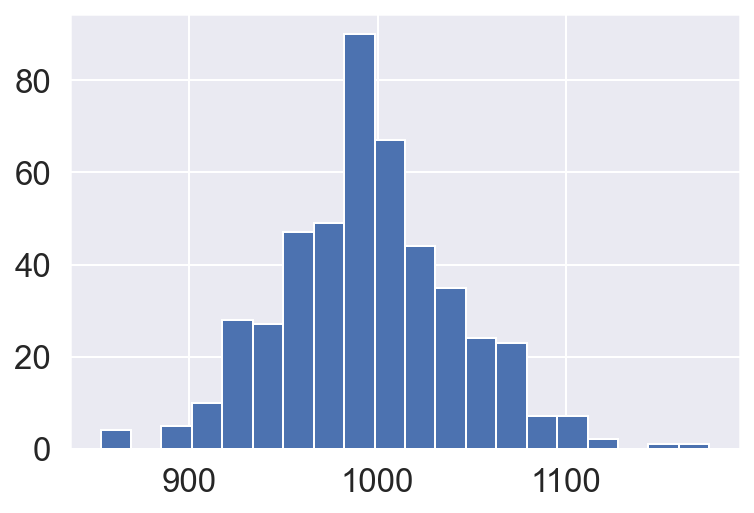

In [29]:
lengths = []
for chapter in chapters['chunks']:
    for chunk in chapter:
        lengths.append(len(chunk))
plt.hist(lengths, bins=20);

In [30]:
len(lengths)

471

In [31]:
chapters['translator'] = 'Alfred Birnbaum'

In [32]:
chapters['book_title'] = 'A Wild Sheep Chase'

In [33]:
chapters.head()

,number,title,text,fstop_indices,split_indices,chunks,translator,book_title
0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",[IT WAS A short one-paragraph item in the mor...,Alfred Birnbaum,A Wild Sheep Chase
1,2,Sixteen Steps,I WAITED FOR the compressed-air hiss of the e...,"[101, 215, 252, 271, 338, 413, 468, 625, 706, ...","[965, 1976, 2982, 3963, 4966, 5989, 6994, 7905...",[I WAITED FOR the compressed-air hiss of the ...,Alfred Birnbaum,A Wild Sheep Chase
2,3,The Slip,"ONCE SHE WAS gone, I downed another cola, the...","[76, 157, 246, 302, 371, 507, 543, 627, 699, 8...","[952, 1904, 2975, 3996, 4929]","[ONCE SHE WAS gone, I downed another cola, th...",Alfred Birnbaum,A Wild Sheep Chase
3,4,The Whale’s Penis and the Woman with Three Occ...,TO SLEEP WITH a woman: it can seem of the utm...,"[125, 229, 420, 514, 598, 686, 788, 874, 937, ...","[937, 1988, 2967, 3981, 4994, 5949, 6936, 7995...",[TO SLEEP WITH a woman: it can seem of the ut...,Alfred Birnbaum,A Wild Sheep Chase
4,5,Unblocked Ears,“ SEE WHAT I mean?” she said. \n She’d becom...,"[30, 84, 129, 178, 243, 314, 382, 481, 541, 56...",[965],[“ SEE WHAT I mean?” she said. \n She’d beco...,Alfred Birnbaum,A Wild Sheep Chase


In [34]:
out_path = '../../../../Documents/murakami/pkl2/'
out_name = 'wsc_birnbaum_v01'
out_full_path = out_path + out_name + '.pkl'

In [36]:
# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(chapters, fp)


# read back pickle
with open (out_full_path, 'rb') as fp:
    read_wsc = pickle.load(fp)

In [38]:
read_wsc

,number,title,text,fstop_indices,split_indices,chunks,translator,book_title
0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",[IT WAS A short one-paragraph item in the mor...,Alfred Birnbaum,A Wild Sheep Chase
1,2,Sixteen Steps,I WAITED FOR the compressed-air hiss of the e...,"[101, 215, 252, 271, 338, 413, 468, 625, 706, ...","[965, 1976, 2982, 3963, 4966, 5989, 6994, 7905...",[I WAITED FOR the compressed-air hiss of the ...,Alfred Birnbaum,A Wild Sheep Chase
2,3,The Slip,"ONCE SHE WAS gone, I downed another cola, the...","[76, 157, 246, 302, 371, 507, 543, 627, 699, 8...","[952, 1904, 2975, 3996, 4929]","[ONCE SHE WAS gone, I downed another cola, th...",Alfred Birnbaum,A Wild Sheep Chase
3,4,The Whale’s Penis and the Woman with Three Occ...,TO SLEEP WITH a woman: it can seem of the utm...,"[125, 229, 420, 514, 598, 686, 788, 874, 937, ...","[937, 1988, 2967, 3981, 4994, 5949, 6936, 7995...",[TO SLEEP WITH a woman: it can seem of the ut...,Alfred Birnbaum,A Wild Sheep Chase
4,5,Unblocked Ears,“ SEE WHAT I mean?” she said. \n She’d becom...,"[30, 84, 129, 178, 243, 314, 382, 481, 541, 56...",[965],[“ SEE WHAT I mean?” she said. \n She’d beco...,Alfred Birnbaum,A Wild Sheep Chase
5,6,The Further Adventures of Unblocked Ears,"THE MANIFESTATION OF her full splendor, thoug...","[67, 229, 311, 369, 415, 450, 494, 560, 631, 7...","[978, 1992, 2974, 3965, 4976]","[THE MANIFESTATION OF her full splendor, thou...",Alfred Birnbaum,A Wild Sheep Chase
6,7,Before the Strange Man,THERE ARE VARIOUS reasons why an individual m...,"[151, 208, 257, 333, 441, 526, 546, 568, 684, ...","[942, 1963, 2878, 3990, 4981, 5977, 6944, 7951...",[THERE ARE VARIOUS reasons why an individual ...,Alfred Birnbaum,A Wild Sheep Chase
7,8,Now the Strange Man,IT WAS ELEVEN o’clock in the morning when the...,"[55, 143, 199, 220, 238, 241, 321, 404, 443, 4...","[924, 1958, 2949, 3961, 4921, 5970, 6975, 7948...",[IT WAS ELEVEN o’clock in the morning when th...,Alfred Birnbaum,A Wild Sheep Chase
8,9,“ The Boss ”,"“ THAT’S THE SIZE of it,” said my partner. \n...","[42, 118, 185, 260, 340, 402, 557, 614, 668, 7...","[942, 1946, 2923, 3917, 4996, 5895, 6959]","[“ THAT’S THE SIZE of it,” said my partner. \...",Alfred Birnbaum,A Wild Sheep Chase
9,10,Counting Sheep,"WE CAN, IF we so choose, wander aimlessly ove...","[78, 154, 245, 317, 509, 612, 738, 763, 828, 8...","[956, 1958, 2971, 3901, 4946]","[WE CAN, IF we so choose, wander aimlessly ov...",Alfred Birnbaum,A Wild Sheep Chase
